# Proyecto: Macroeconometría 2023-I (UdeP) 

### Integrantes del grupo:
- Ivana Basurco
- Nataly Grados
- Noelia Luque
- Francesco Ricci
- Enrique Sánchez

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,r2_score # pip install sklearn
import pmdarima as pm # Install -> pip install pmdarima

## Definicion de DataFrames

In [2]:
baseDF = pd.read_excel('dataema.xlsx')
baseDF = baseDF.set_index(["Fecha"])

baseDF = baseDF.drop(['IPC'], axis=1)
baseDF = baseDF.drop(['P. Petroleo'], axis=1)
baseDF = baseDF.drop(['M1'], axis=1)
baseDF = baseDF.drop(['Expect'], axis=1)
baseDF = baseDF.drop(['TC'], axis=1)

baseDF

,IPC%
Fecha,
2003-01-01,0.231420
2003-02-01,0.468825
2003-03-01,1.117780
2003-04-01,-0.050857
2003-05-01,-0.032025
...,...
2023-01-01,0.226447
2023-02-01,0.294523
2023-03-01,1.253487


In [3]:
TESTINGPERCENT = 5

separacion = int(len(baseDF) * TESTINGPERCENT/100)

def divData(df, n):
    df_train, df_test = df[0:-n], df[-n:]

    # Check size
    print("Training set shape: ", df_train.shape)
    print("Testing set shape: ", df_test.shape)

    return df_train, df_test

In [4]:
trainDF, testDF = divData(baseDF, separacion)

Training set shape:  (233, 1)
Testing set shape:  (12, 1)


<Axes: xlabel='Fecha'>

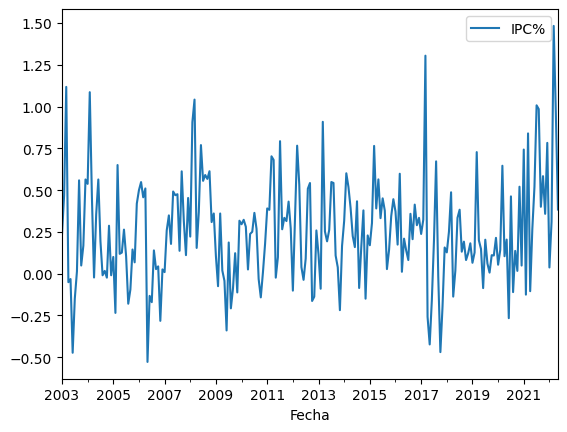

In [5]:
trainDF.plot()

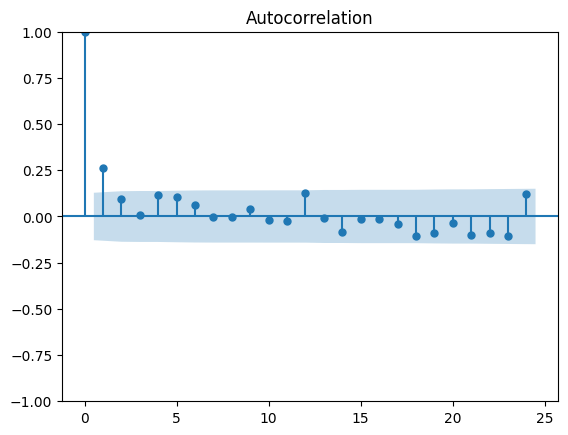

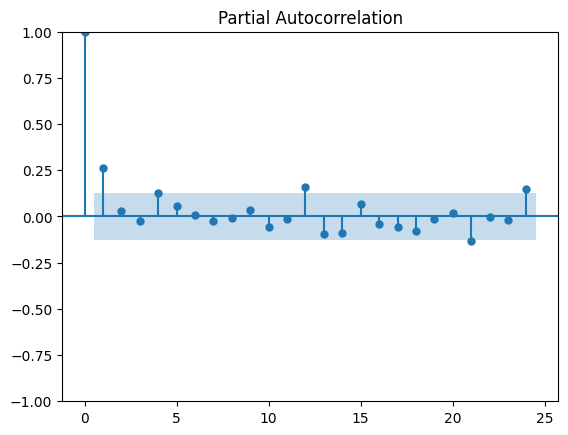

In [6]:
acf_original = plot_acf(trainDF)
pacf_original = plot_pacf(trainDF)

In [7]:
adf_test = adfuller(trainDF)
print(f'p-value: {adf_test[1]}')

p-value: 5.166114771456734e-07


<Axes: xlabel='Fecha'>

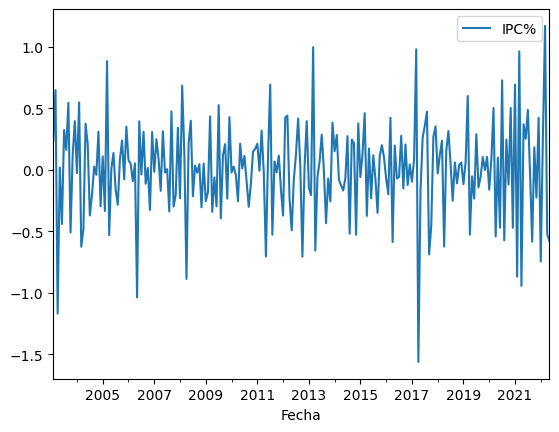

In [8]:
df_train_diff = trainDF.diff().dropna()
df_train_diff.plot()

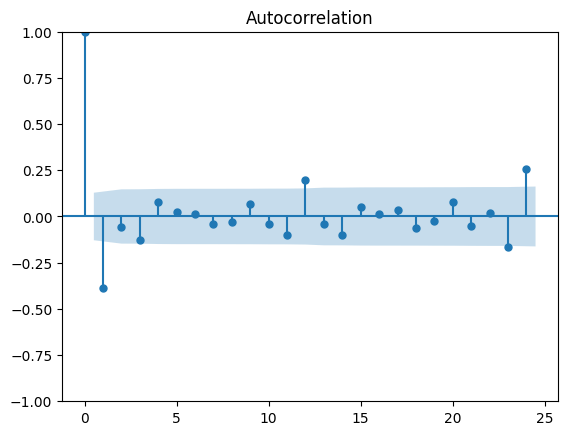

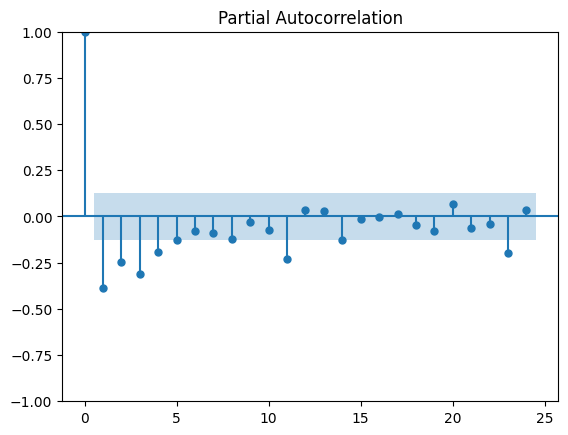

In [9]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [10]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 8.390934788738603e-13


## Modelo ARIMA definido manualmente

In [11]:
model = ARIMA(trainDF, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   IPC%   No. Observations:                  233
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -53.333
Date:                Wed, 16 Aug 2023   AIC                            114.665
Time:                        20:06:30   BIC                            128.469
Sample:                    01-01-2003   HQIC                           120.231
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2525      0.030      8.413      0.000       0.194       0.311
ar.L1          0.3643      0.266      1.367      0.172      -0.158       0.886
ma.L1         -0.1125      0.270     -0.417      0.6

C:\Users\kikes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\kikes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\kikes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


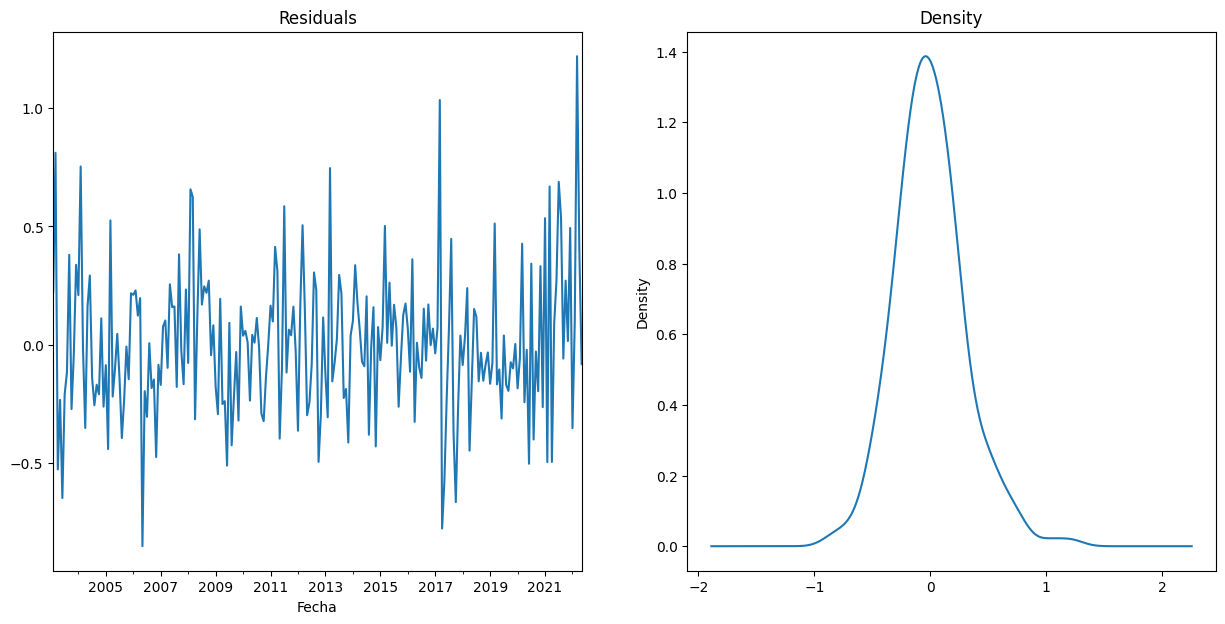

In [12]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
fig.set_size_inches(15,7)
plt.show()

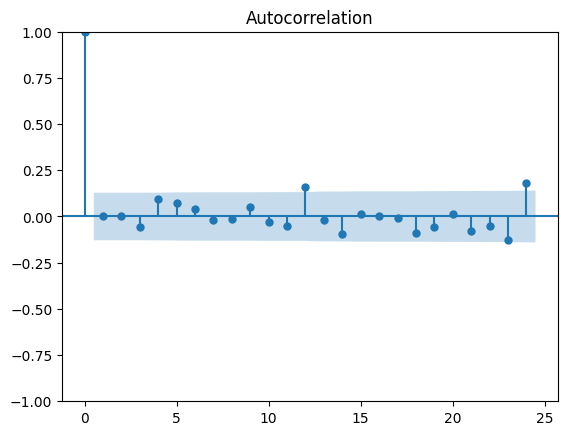

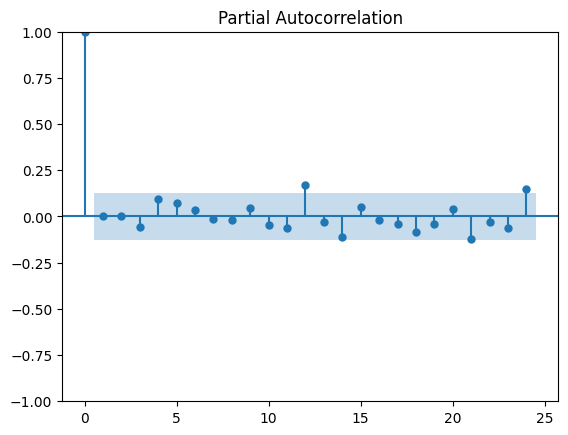

In [13]:
acf_res=plot_acf(residuals)
pacf_res=plot_pacf(residuals)

In [14]:
juneEntry = pd.DataFrame.from_dict(data={"Fecha": ['2023-06-01'], 'IPC%': [None]})
juneEntry = juneEntry.set_index("Fecha")
juneEntry

juneEntry.index = pd.to_datetime(juneEntry.index)
baseDF = pd.concat([baseDF, juneEntry])
baseDF

,IPC%
Fecha,
2003-01-01,0.231420
2003-02-01,0.468825
2003-03-01,1.117780
2003-04-01,-0.050857
2003-05-01,-0.032025
...,...
2023-02-01,0.294523
2023-03-01,1.253487
2023-04-01,0.556252


<Axes: xlabel='Fecha'>

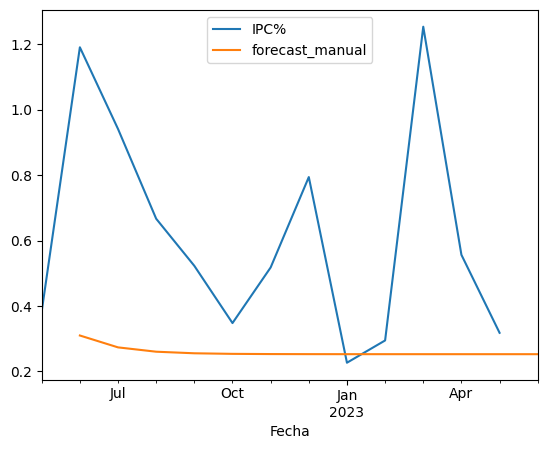

In [15]:
forecast_test = model_fit.forecast(len(testDF) + 1)

baseDF['forecast_manual'] = [None]*len(trainDF) + list(forecast_test)

baseDF[-int(len(testDF)*1.2):].plot()

## Modelo Auto-ARIMA

In [16]:
auto_arima = pm.auto_arima(trainDF, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [17]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  233
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -56.205
Date:                Wed, 16 Aug 2023   AIC                            122.411
Time:                        20:06:34   BIC                            139.666
Sample:                    01-01-2003   HQIC                           129.369
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3610      0.265      5.134      0.000       0.841       1.881
ar.L2         -0.3611      0.265     -1.363      0.173      -0.880       0.158
ma.L1         -1.0926      0.269     -4.057      0.000      -1.620      -0.565
ma.L2          0.1021      0.263      0.388      0.698      -0.414       0.618
sigma2         0.0931      0.007     13.503      0.000       0.080       0.107
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                22.64
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.49
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Fecha'>

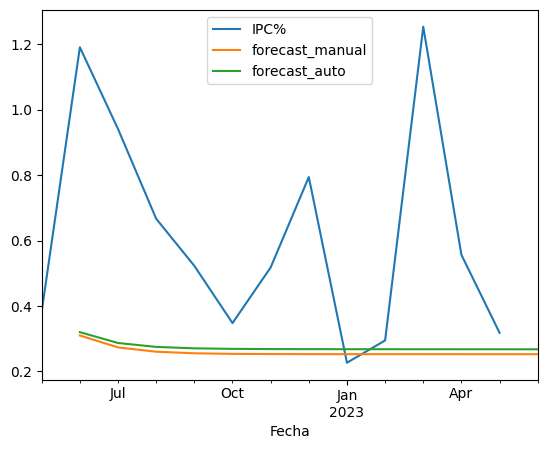

In [18]:
forecast_test_auto = auto_arima.predict(n_periods=len(testDF) + 1)
baseDF['forecast_auto'] = [None]*len(trainDF) + list(forecast_test_auto)

baseDF[-int(len(testDF)*1.2):].plot()

Prediccion de Junio:


In [19]:
baseDF[-1:]

,IPC%,forecast_manual,forecast_auto
Fecha,,,
2023-06-01,NaN,0.25254,0.267504


## Metricas de Precision

In [20]:
mae = mean_absolute_error(testDF, forecast_test[:-1])
mape = mean_absolute_percentage_error(testDF, forecast_test[:-1])
mse = mean_squared_error(testDF, forecast_test[:-1])
rmse = np.sqrt(mean_squared_error(testDF, forecast_test[:-1]))
r2 = r2_score(testDF, forecast_test[:-1])


print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'mse - manual: {mse}')
print(f'rmse - manual: {rmse}')
print(f'r2 - manual: {r2}')

mae - manual: 0.3800296324463135
mape - manual: 0.4868660148109282
mse - manual: 0.24425319738761345
rmse - manual: 0.494219786519736
r2 - manual: -1.2380028039812556


In [21]:
mae = mean_absolute_error(testDF, forecast_test_auto[:-1])
mape = mean_absolute_percentage_error(testDF, forecast_test_auto[:-1])
mse = mean_squared_error(testDF, forecast_test_auto[:-1])
rmse = np.sqrt(mean_squared_error(testDF, forecast_test_auto[:-1]))
r2 = r2_score(testDF, forecast_test_auto[:-1])


print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'mse - auto: {mse}')
print(f'rmse - auto: {rmse}')
print(f'r2 - auto: {r2}')

mae - auto: 0.36800843752927775
mape - auto: 0.4671187444121152
mse - auto: 0.23404266568132112
rmse - auto: 0.4837795631083656
r2 - auto: -1.1444474326157033


## Bibliografía
- https://www.youtube.com/watch?v=-aCF0_wfVwY